<a href="https://colab.research.google.com/github/moosunny/EfficientNetV2_CAM/blob/main/EfficientNetV2_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Orange Disease Classification

In [ ]:
# 필요 라이브 러리 정리
import kagglehub
import os
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import numpy as np

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import random_split

# Metric
from torchmetrics.classification import Accuracy, F1Score
from sklearn.metrics import confusion_matrix

# Grad-CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


In [ ]:
import kagglehub

# Orange Disease Classification 데이터셋 주소 in Kaggle
path = kagglehub.dataset_download("jonathansilva2020/orange-diseases-dataset")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jonathansilva2020/orange-diseases-dataset/versions/3


In [ ]:
import os

print(os.listdir(path = path))
print(os.listdir(path = path + "/train"))
print(os.listdir(path = path + "/test"))
train_path = path + "/train"
test_path = path + "/test"

['test', 'train']
['fresh', 'canker', 'grenning', 'blackspot']
['fresh', 'canker', 'grenning', 'blackspot']


# 데이터 EDA

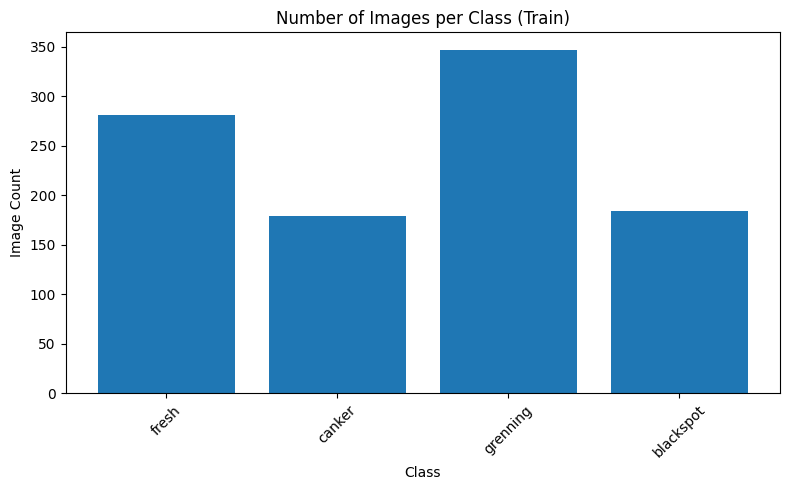

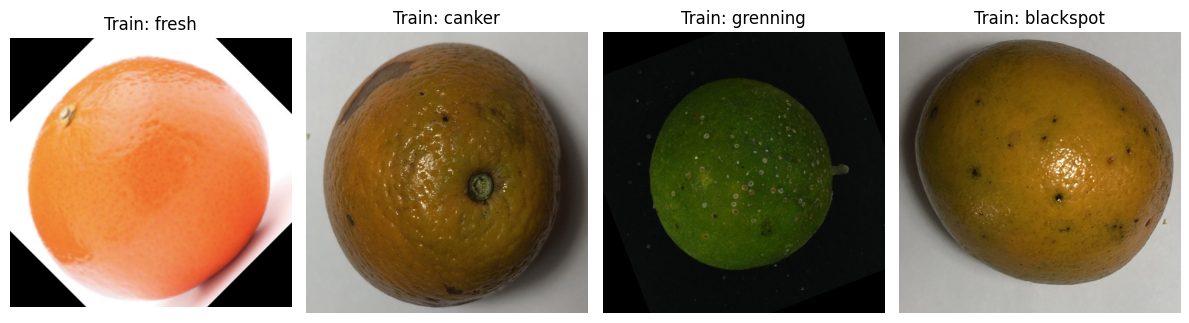

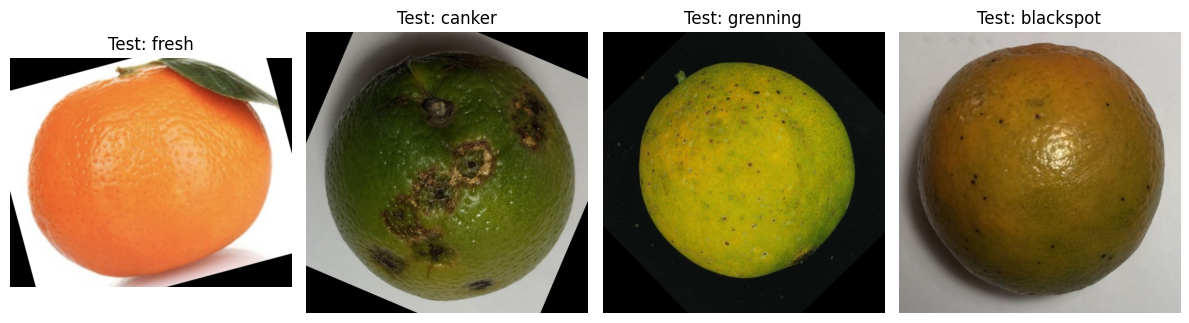

In [ ]:
from collections import defaultdict

def get_class_distribution(data_dir):
    class_counts = defaultdict(int)
    class_paths = {}

    for class_name in os.listdir(data_dir):
        class_folder = os.path.join(data_dir, class_name)
        if os.path.isdir(class_folder):
            image_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
            class_counts[class_name] = len(image_files)
            class_paths[class_name] = [os.path.join(class_folder, img) for img in image_files]

    return class_counts, class_paths

# 1. Train 클래스 분포 시각화
train_counts, train_paths = get_class_distribution(train_path)

plt.figure(figsize=(8, 5))
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Number of Images per Class (Train)")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. 클래스별 샘플 이미지 (Train)
plt.figure(figsize=(12, 6))
for i, (class_name, paths) in enumerate(train_paths.items()):
    img = Image.open(paths[0])
    plt.subplot(1, len(train_paths), i+1)
    plt.imshow(img)
    plt.title(f"Train: {class_name}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# 3. 클래스별 샘플 이미지 (Test)
_, test_paths = get_class_distribution(test_path)

plt.figure(figsize=(12, 6))
for i, (class_name, paths) in enumerate(test_paths.items()):
    img = Image.open(paths[0])
    plt.subplot(1, len(test_paths), i+1)
    plt.imshow(img)
    plt.title(f"Test: {class_name}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 데이터셋 함수
class CustomImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        if not (path.endswith(".jpg") or path.endswith(".png")):
            return None
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [ ]:
import torchvision.models as models

# EfficientNet_V2 모델 다운로드, 파라미터 사이즈에 따라 S,M,L 순서로 활용 가능
model_s = models.efficientnet_v2_s(weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model_m = models.efficientnet_v2_m(weights = models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
model_l = models.efficientnet_v2_l(weights = models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 119MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:04<00:00, 43.7MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:08<00:00, 56.4MB/s]


In [ ]:
# 모델 파라미터 개수 취합
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("EfficientNet_V2_S 파라미터 개수:",count_parameters(model_s))
print("EfficientNet_V2_M 파라미터 개수:",count_parameters(model_m))
print("EfficientNet_V2_L 파라미터 개수:",count_parameters(model_l))

EfficientNet_V2_S 파라미터 개수: 21458488
EfficientNet_V2_M 파라미터 개수: 54139356
EfficientNet_V2_L 파라미터 개수: 118515272


In [ ]:
# !pip install torchview
# EfficientNet V2 Small 모델의 레이어 시각화
from torchview import draw_graph

# 모델 시각화 생성
model_graph = draw_graph(model_s, input_size=(1, 3, 384, 384), expand_nested=True)
model_graph.visual_graph.render("efficientnetv2_s_architecture", format="png")

'efficientnetv2_s_architecture.png'

In [ ]:
from torch.utils.data import Dataset, DataLoader

model_s_weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
model_m_weights = models.EfficientNet_V2_M_Weights.IMAGENET1K_V1
model_l_weights = models.EfficientNet_V2_L_Weights.IMAGENET1K_V1

print(model_s_weights.transforms())
print(model_m_weights.transforms())
print(model_l_weights.transforms())

train_dir = "/root/.cache/kagglehub/datasets/jonathansilva2020/orange-diseases-dataset/versions/3/train"
test_dir = "/root/.cache/kagglehub/datasets/jonathansilva2020/orange-diseases-dataset/versions/3/test"

train_dataset_model_s = CustomImageFolder(train_path, transform=model_s_weights.transforms())
train_dataset_model_m = CustomImageFolder(train_path, transform=model_m_weights.transforms())
train_dataset_model_l = CustomImageFolder(train_path, transform=model_l_weights.transforms())

test_dataset_model_s = CustomImageFolder(test_path, transform=model_s_weights.transforms())
test_dataset_model_m = CustomImageFolder(test_path, transform=model_m_weights.transforms())
test_dataset_model_l = CustomImageFolder(test_path, transform=model_l_weights.transforms())

model_s = models.efficientnet_v2_s(weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model_m = models.efficientnet_v2_m(weights = models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
model_l = models.efficientnet_v2_l(weights = models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)

from torch.utils.data import random_split

# 모델별 weights와 datasets을 dict로 정리
model_weights = {
    "s": model_s_weights,
    "m": model_m_weights,
    "l": model_l_weights
}

train_datasets = {
    "s": train_dataset_model_s,
    "m": train_dataset_model_m,
    "l": train_dataset_model_l
}

# 결과 저장용 dict
train_loaders = {}
val_loaders = {}


val_ratio = 0.2
batch_size = 32
seed = 42

for key in ["s", "m", "l"]:
    dataset = train_datasets[key]
    weight = model_weights[key]

    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size

    train_subset, val_subset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

    # transform 다시 지정
    train_subset.dataset.transform = weight.transforms()
    val_subset.dataset.transform = weight.transforms()

    # DataLoader 만들기
    train_loaders[key] = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loaders[key] = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    interpolation=InterpolationMode.BICUBIC
)


In [ ]:
from torch.utils.data import random_split
from tqdm import tqdm

# 모델별 weights와 datasets을 dict로 정리
model_weights = {
    "s": model_s_weights,
    "m": model_m_weights,
    "l": model_l_weights
}

train_datasets = {
    "s": train_dataset_model_s,
    "m": train_dataset_model_m,
    "l": train_dataset_model_l
}

# 결과 저장용 dict
train_loaders = {}
val_loaders = {}

# 공통 설정
val_ratio = 0.2
batch_size = 32
seed = 42

for key in ["s", "m", "l"]:
    dataset = train_datasets[key]
    weight = model_weights[key]

    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size

    train_subset, val_subset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

    # transform 다시 지정
    train_subset.dataset.transform = weight.transforms()
    val_subset.dataset.transform = weight.transforms()

    # DataLoader 만들기
    train_loaders[key] = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loaders[key] = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

test_dataset_model_s = CustomImageFolder(test_path, transform=model_s_weights.transforms())
test_dataset_model_m = CustomImageFolder(test_path, transform=model_m_weights.transforms())
test_dataset_model_l = CustomImageFolder(test_path, transform=model_l_weights.transforms())

test_loader_model_s = DataLoader(test_dataset_model_s, batch_size= 32)
test_loader_model_m = DataLoader(test_dataset_model_m, batch_size= 32)
test_loader_model_l = DataLoader(test_dataset_model_l, batch_size= 32)

# 모델의 분류기 출력 차원 수정
model_s.classifier[-1] = nn.Linear(1280, len(train_dataset_model_s.classes))
model_m.classifier[-1] = nn.Linear(1280, len(train_dataset_model_m.classes))
model_l.classifier[-1] = nn.Linear(1280, len(train_dataset_model_l.classes))

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, model_name="", num_classes=None):
    model.to(device)

    # 로그 저장용 리스트
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    val_f1_list = []

    f1_metric = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"[{model_name}] Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_train_loss = running_loss / len(train_loader)

        # === 검증 ===
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_total = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                all_preds.append(preds)
                all_labels.append(labels)

        val_acc = val_correct / val_total
        avg_val_loss = val_loss_total / len(val_loader)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        val_f1 = f1_metric(all_preds, all_labels).item()


        # 리스트에 저장
        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)

        print(f"[{model_name}] Epoch {epoch+1} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | F1: {val_f1:.4f}\n")

    # === 시각화 ===
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(16, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss_list, label='Train Loss')
    plt.plot(epochs, val_loss_list, label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc_list, label='Train Acc')
    plt.plot(epochs, val_acc_list, label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1_list, label='Val F1 Score', color='green')
    plt.title(f'{model_name} F1 Score')
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix 시각화 함수
def plot_confusion_matrix(preds, labels, class_names, normalize=False):
    cm = confusion_matrix(labels.cpu(), preds.cpu(), normalize='true' if normalize else None)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.tight_layout()
    return fig

# Test 함수
def evaluate_model(model, dataloader, num_classes, device, model_name=""):
    model.eval()
    accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    f1 = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Evaluating {model_name}"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc_value = accuracy(all_preds, all_labels).item()
    f1_value = f1(all_preds, all_labels).item()

    print(f"[{model_name}] Test Accuracy: {acc_value * 100:.2f}% | F1 Score: {f1_value:.4f}")

    # 클래스 이름으로 confusion matrix 시각화
    class_names = ['blackspot', 'canker', 'fresh', 'grenning']
    fig = plot_confusion_matrix(all_preds, all_labels, class_names, normalize=True)
    plt.title(f"Confusion Matrix_{model_name}")
    plt.show()

    return acc_value, f1_value

## Grad-CAM 프로세스

1. **타겟 클래스에 대한 출력값을 기준으로, 특정 convolutional layer의 feature map에 대한 gradient를 계산**  
   → 보통 **마지막 convolutional layer**를 타겟으로 설정하며, 이 레이어의 feature map에 대해 gradient를 도출

2. **해당 gradient를 채널별로 global average pooling하여, 각 feature map 채널의 weight로 사용**  
   → 이 weight는 각 채널이 해당 클래스에 **얼마나 중요한지**를 나타냄

3. **각 채널의 feature map에 위에서 구한 weight를 곱한 후, 이들을 더하고 ReLU를 적용**

   수식:

   $$
   \text{Grad-CAM} = \text{ReLU} \left( \sum_k \alpha_k A^k \right)
   $$

   - $A^k$: $k$번째 채널의 feature map  
   - $\alpha_k $: 해당 채널에 대한 weight (gradient를 global average pooling한 값)

4. **얻어진 activation map을 원본 이미지 크기로 interpolation하여 시각화**  
   → 주로 **heatmap**으로 나타내며, **원본 이미지 위에 overlay**해서 해석할 수 있도록 만듦


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image

CLASS_NAMES = ['blackspot', 'canker', 'fresh', 'grenning']

def get_mean_std_from_weights(weights):
    return np.array(weights.transforms().mean), np.array(weights.transforms().std)

def visualize_gradcam_by_class(model, test_dataset, weights, device='cuda'):
    model.eval()
    model.to(device)

    mean, std = get_mean_std_from_weights(weights)
    target_layer = model.features[-1][0]
    cam = GradCAM(model=model, target_layers=[target_layer], device=device)

    cam_images = []  # CAM 이미지들을 저장할 리스트
    titles = []      # 클래스 이름 저장용

    for class_idx, class_name in enumerate(CLASS_NAMES):
        for image, label in test_dataset:
            if label == class_idx:
                input_tensor = image.unsqueeze(0).to(device)
                targets = [ClassifierOutputTarget(class_idx)]
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

                rgb_image = image.permute(1, 2, 0).cpu().numpy()
                rgb_image = np.clip((rgb_image * std) + mean, 0, 1)
                cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

                cam_images.append(cam_image)
                titles.append(class_name)
                break  # 다음 클래스로 넘어감


    num_classes = len(cam_images)
    fig, axs = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))

    for i in range(num_classes):
        axs[i].imshow(cam_images[i])
        axs[i].axis('off')
        axs[i].set_title(f"Class: {titles[i]}", fontsize=14)

    plt.tight_layout()
    plt.show()

Evaluating EfficientNetV2-S: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


[EfficientNetV2-S] Test Accuracy: 32.32% | F1 Score: 0.3127


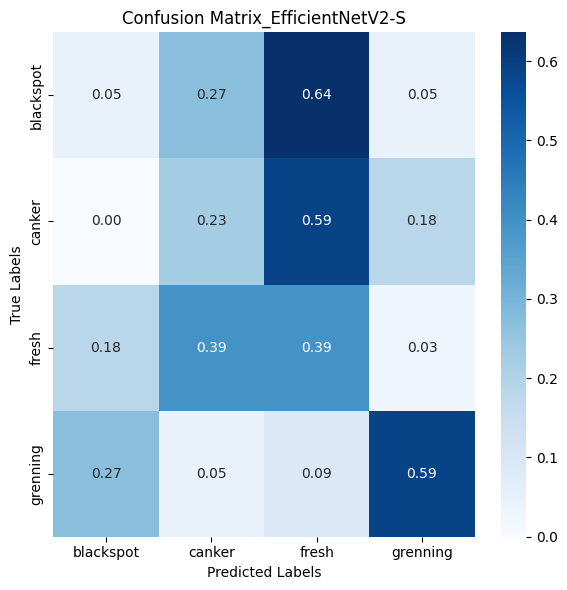

Evaluating EfficientNetV2-M: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

[EfficientNetV2-M] Test Accuracy: 23.23% | F1 Score: 0.1258


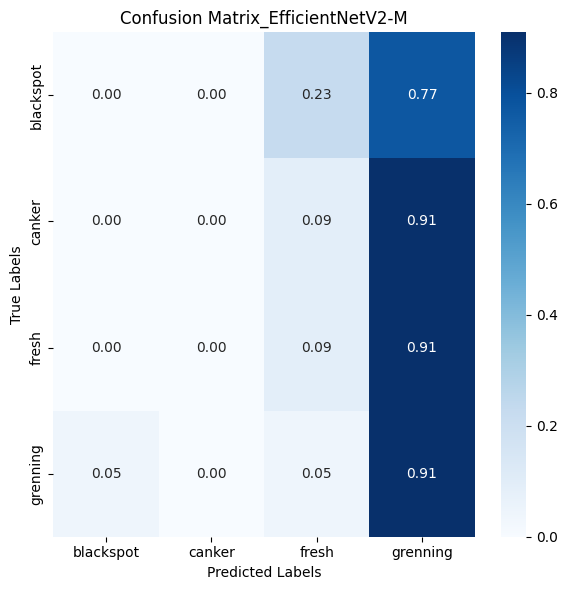

Evaluating EfficientNetV2-L: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

[EfficientNetV2-L] Test Accuracy: 21.21% | F1 Score: 0.1267


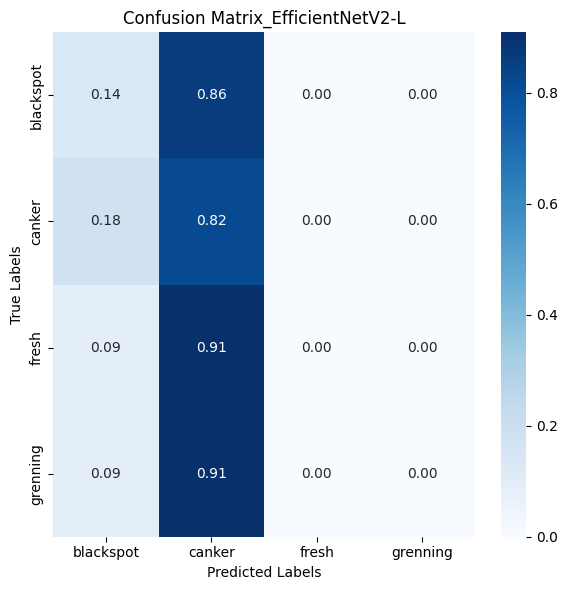

In [ ]:
from torchmetrics.classification import Accuracy, F1Score

NUM_CLASSES = len(train_dataset_model_s.classes)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_s = model_s.to(device)
model_m = model_m.to(device)
model_l = model_l.to(device)

class_names = train_dataset_model_s.classes  # ImageFolder 기반이면 클래스 순서 자동 포함




acc_s, f1_s = evaluate_model(model = model_s, dataloader=test_loader_model_s, num_classes=NUM_CLASSES, device=device, model_name="EfficientNetV2-S")
acc_m, f1_m = evaluate_model(model_m, test_loader_model_m, NUM_CLASSES, device, model_name = "EfficientNetV2-M")
acc_l, f1_l = evaluate_model(model_l, test_loader_model_l, NUM_CLASSES, device, model_name = "EfficientNetV2-L")

[EfficientNetV2-S] Epoch 1/10: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


[EfficientNetV2-S] Epoch 1 | Train Loss: 0.4933 | Train Acc: 91.05% | Val Loss: 0.0648 | Val Acc: 98.99% | F1: 0.9876



[EfficientNetV2-S] Epoch 2/10: 100%|██████████| 25/25 [00:16<00:00,  1.51it/s]


[EfficientNetV2-S] Epoch 2 | Train Loss: 0.0541 | Train Acc: 98.87% | Val Loss: 0.0724 | Val Acc: 97.47% | F1: 0.9690



[EfficientNetV2-S] Epoch 3/10: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]


[EfficientNetV2-S] Epoch 3 | Train Loss: 0.0246 | Train Acc: 99.50% | Val Loss: 0.1388 | Val Acc: 95.96% | F1: 0.9500



[EfficientNetV2-S] Epoch 4/10: 100%|██████████| 25/25 [00:16<00:00,  1.51it/s]


[EfficientNetV2-S] Epoch 4 | Train Loss: 0.0419 | Train Acc: 98.61% | Val Loss: 0.0396 | Val Acc: 98.99% | F1: 0.9876



[EfficientNetV2-S] Epoch 5/10: 100%|██████████| 25/25 [00:15<00:00,  1.58it/s]


[EfficientNetV2-S] Epoch 5 | Train Loss: 0.0155 | Train Acc: 99.75% | Val Loss: 0.0408 | Val Acc: 98.99% | F1: 0.9877



[EfficientNetV2-S] Epoch 6/10: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]


[EfficientNetV2-S] Epoch 6 | Train Loss: 0.0121 | Train Acc: 99.87% | Val Loss: 0.0573 | Val Acc: 98.48% | F1: 0.9814



[EfficientNetV2-S] Epoch 7/10: 100%|██████████| 25/25 [00:16<00:00,  1.50it/s]


[EfficientNetV2-S] Epoch 7 | Train Loss: 0.0070 | Train Acc: 99.87% | Val Loss: 0.0371 | Val Acc: 98.48% | F1: 0.9815



[EfficientNetV2-S] Epoch 8/10: 100%|██████████| 25/25 [00:16<00:00,  1.52it/s]


[EfficientNetV2-S] Epoch 8 | Train Loss: 0.0071 | Train Acc: 99.87% | Val Loss: 0.0999 | Val Acc: 97.98% | F1: 0.9752



[EfficientNetV2-S] Epoch 9/10: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]


[EfficientNetV2-S] Epoch 9 | Train Loss: 0.0069 | Train Acc: 100.00% | Val Loss: 0.0175 | Val Acc: 98.99% | F1: 0.9877



[EfficientNetV2-S] Epoch 10/10: 100%|██████████| 25/25 [00:16<00:00,  1.52it/s]


[EfficientNetV2-S] Epoch 10 | Train Loss: 0.0143 | Train Acc: 99.50% | Val Loss: 0.0279 | Val Acc: 98.48% | F1: 0.9815



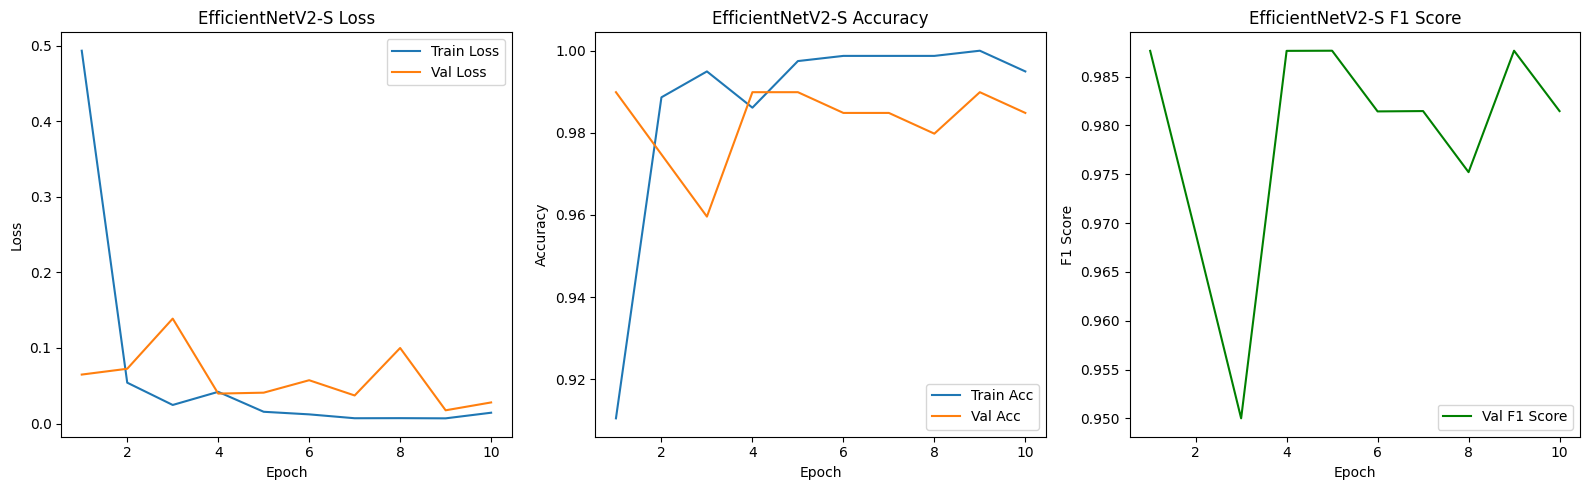

In [ ]:
EPOCHS = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer_s = torch.optim.Adam(model_s.parameters(), lr=1e-4)



train_model(
    model=model_s,
    train_loader=train_loaders["s"],
    val_loader=val_loaders["s"],
    optimizer=optimizer_s,
    criterion=criterion,
    device=device,
    num_epochs=10,
    model_name="EfficientNetV2-S",
    num_classes=NUM_CLASSES
)

Evaluating EfficientNetV2-S: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

[EfficientNetV2-S] Test Accuracy: 98.99% | F1 Score: 0.9886


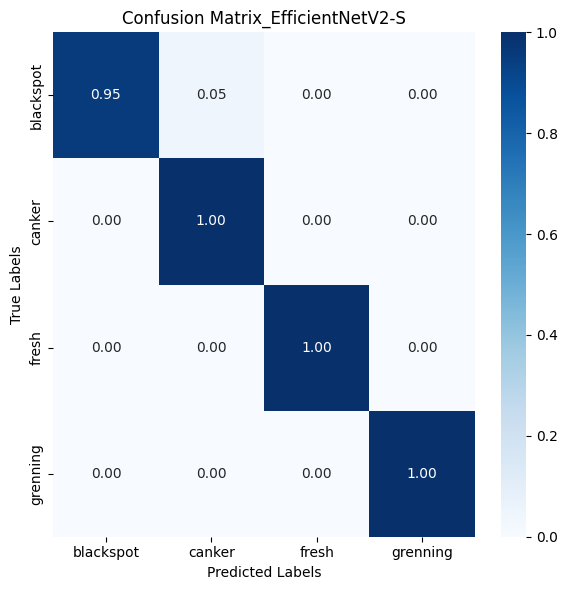

(0.9898989796638489, 0.988630473613739)

In [ ]:
evaluate_model(model = model_s, dataloader=test_loader_model_s, num_classes=NUM_CLASSES, device=device, model_name="EfficientNetV2-S")

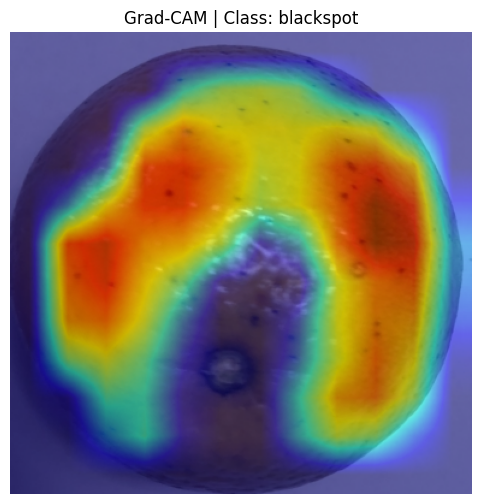

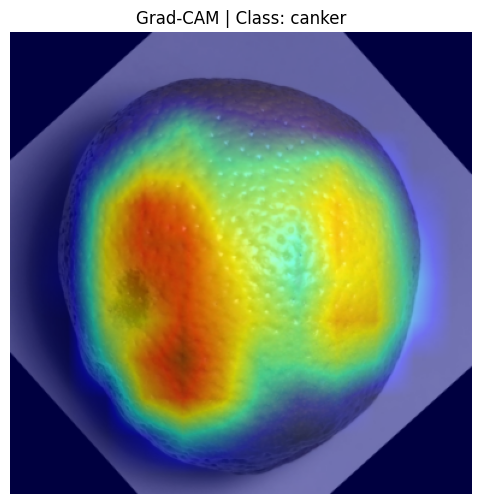

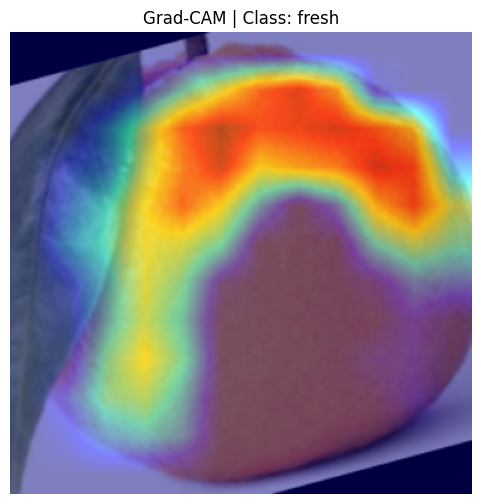

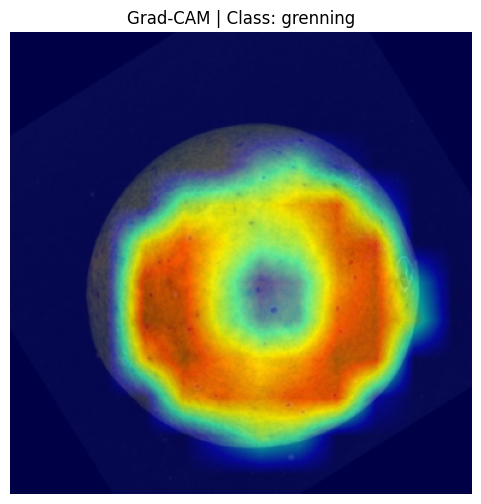

In [ ]:
visualize_gradcam_by_class(
    model=model_s,
    test_dataset=test_dataset_model_s,
    weights=model_weights["s"],
    device=device
)

In [ ]:
optimizer_m = torch.optim.Adam(model_m.parameters(), lr=1e-4)

train_model(
    model=model_m,
    train_loader=train_loaders["m"],
    val_loader=val_loaders["m"],
    optimizer=optimizer_m,
    criterion=criterion,
    device=device,
    num_epochs=10,
    model_name="EfficientNetV2-S",
    num_classes=NUM_CLASSES
)

In [ ]:
evaluate_model(model = model_m, dataloader=test_loader_model_m, num_classes=NUM_CLASSES, device=device, model_name="EfficientNetV2-M")

In [ ]:
visualize_gradcam_by_class(
    model=model_m,
    test_dataset=test_dataset_model_m,
    weights=model_weights["m"],
    device=device
)

In [ ]:
# optimizer_l = torch.optim.Adam(model_l.parameters(), lr=1e-4)

# train_model(
#     model=model_l,
#     train_loader=train_loaders["l"],
#     val_loader=val_loaders["l"],
#     optimizer=optimizer_l,
#     criterion=criterion,
#     device=device,
#     num_epochs=10,
#     model_name="EfficientNetV2-L",
#     num_classes=NUM_CLASSES
# )

In [ ]:
evaluate_model(model = model_l, dataloader=test_loader_model_l, num_classes=NUM_CLASSES, device=device, model_name="EfficientNetV2-L")